In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Using TensorFlow backend.


Le module display permet d'afficher les maillages et les résultats des procédures d'estimation des paramètres.

La fonction create_organo permet d'initialiser un organoïde régulier. Elle prend en paramètre :

- nb_cells: le nombre de cellules dans le maillage.
- r_in : le rayon de la membrane apicale de l'organoïde.
- r_out: le rayon de la membrane basale de l'organoïde.
- rot (optionnel): defaut = None. Une rotation à appliquer sur les vertex en radians.
- geom (optionnel): dafaut = tyssue_taylor.models.annular.AnnularGeometry. tyssue geometry class

Après avoir initialiser le maillage, il faut mettre à jour avec geom.update_all. On peut aussi résoudre pour le minimum d'énergie.

In [2]:
nf, r_in, r_out = (10, 1, 2)
organo = create_organo(nf, r_in, r_out)

geom.update_all(organo)
_ = Solver.find_energy_min(organo, geom, model)

Reseting datasets values with new specs


La fonction print_tensions permet d'afficher un maillage expérimental et les tensions associées à chacun de ses edges en sur-impression d'un organoïde théorique. Elle prend en paramètres :

- exp_organo: l'organoïde expérimental
- th_organo: l'organoïde théorique

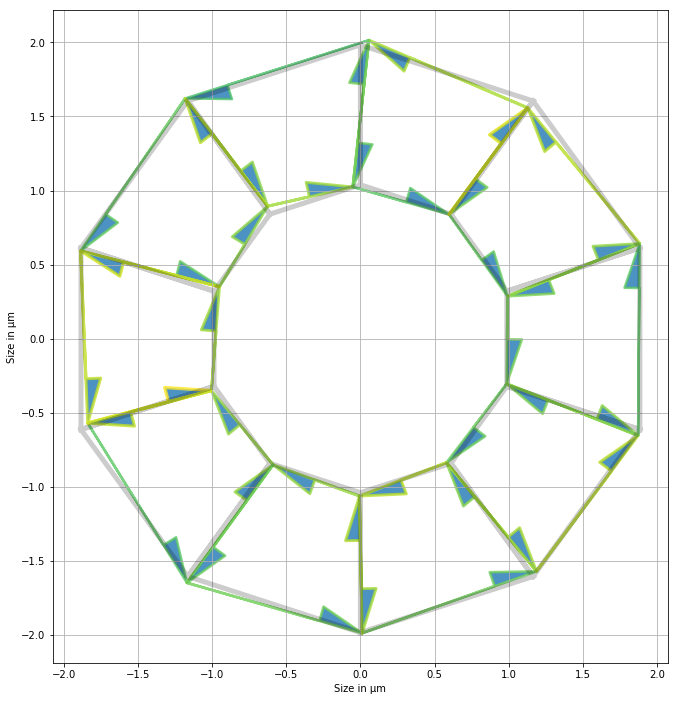

In [3]:
to_display_org = organo.copy()
to_display_org.edge_df.loc[:, 'line_tension'] = organo.edge_df.line_tension.values + np.random.normal(0, 0.01, organo.Ne)

_ = Solver.find_energy_min(to_display_org, geom, model)

print_tensions(to_display_org, organo)

La fonction rendering_results permet d'afficher un comparatif des résultats obtenus et des vrais paramètres, et prend comme paramètres :

- organo: un maillage de class AnnularSheet auquel les données peuvent être associées
- x_data: les données à placer en abscisses, à priori les vrais paramètres
- y_data: les données à placer en ordonnées, à priori les paramètres inférés
- title: titre du graphique
- xlabel: titre de l'axe des abscisses
- ylabel: titre de l'axe des ordonnées
- legend: légende associée au graphique sous la forme d'un vecteur de strings.

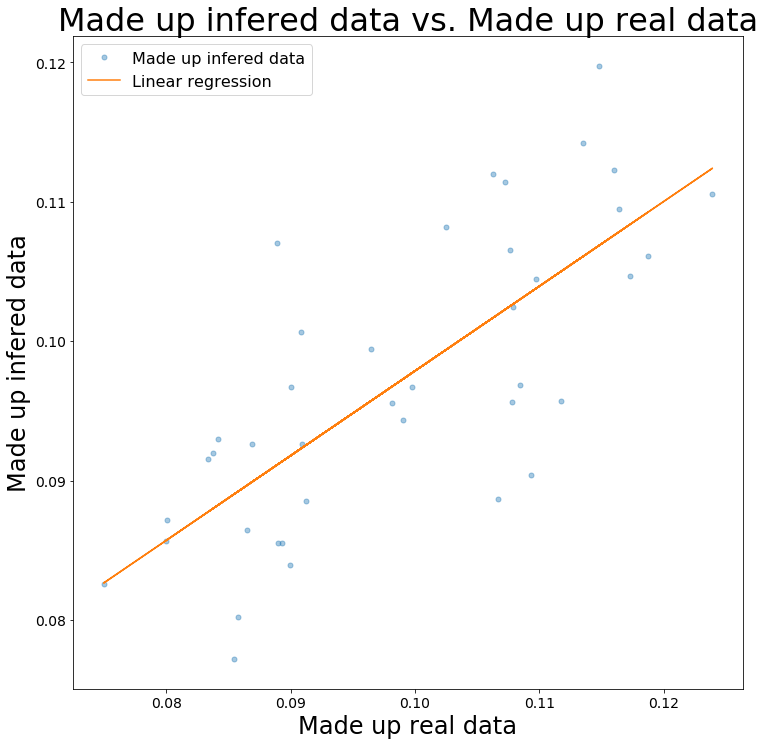

R value : 0.7501262733097274 
Standard error : 0.00688712387751902


In [4]:
made_up_infered_param = organo.edge_df.line_tension.values + np.random.normal(0, 0.01, organo.Ne)

made_up_real_param = made_up_infered_param + np.random.normal(0, 0.01, organo.Ne)

rendering_results(organo,
                  made_up_real_param,
                  made_up_infered_param,
                  "Made up infered data vs. Made up real data",
                  "Made up real data",
                  "Made up infered data",
                  ("Made up infered data", "Linear regression"))

Enfin si l'on lance la procédure de recalage en enregistrant les appels de la fonction coût, on peut utiliser la fonction rendering_convergence_results pour afficher ces résultats. Cette fonction prend en paramètres :

- x_data: les données à placer en abscisses, à priori le nombre d'appels de la fonction coût
- y_data: les données à placer en ordonnées, à priori les valeurs de la fonction coût
- title: titre du graphique
- xlabel: titre de l'axe des abscisses
- ylabel: titre de l'axe des ordonnées
- legend: légende associée au graphique sous la forme d'un vecteur de strings.
- data_dot (optionnel): defaut = '-'. Mise en forme des points de donnée
- rol_win (optionnel): defaut = 50. Largeur de la fenêtre de la moyenne mobile sur les valeurs de la fonction coût.

In [5]:
#Dans un premier temps on appelle la procédure de recalage. Voir documentation notebook adjusters/adjust_params
init_t = (organo.edge_df.line_tension.values + np.random.normal(0.0, 0.01, organo.Ne))[:3*organo.Nf]
init_a = organo.face_df.prefered_area.values + np.random.normal(0.0, 0.01, organo.Nf)
init_l = organo.settings['lumen_prefered_vol'] +  np.random.normal(0.0, 0.01, 1)

init_point = np.r_[init_t, init_a, init_l]

lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-4, 'verbose': 0}

start = time.time()
res = adjust_parameters(organo, init_point, iprint_file="conv_report.txt", **lm_opt)
end = time.time() - start
print("Solving time = ", end,
      "   |   f(x*) = ", np.sum(res.fun))

Solving time =  98.547039270401    |   f(x*) =  0.0


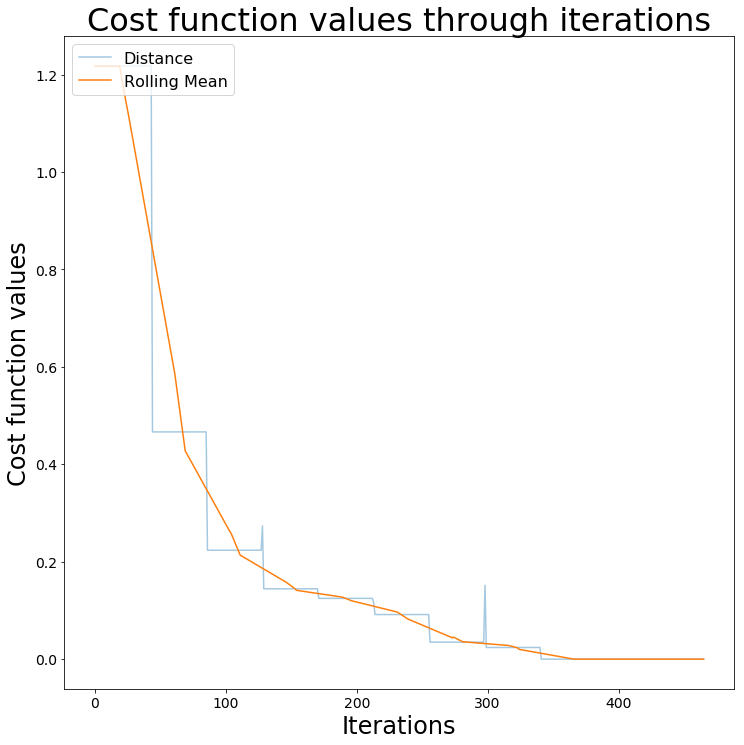

In [6]:
obj_values = pd.read_csv("conv_report.txt", header=None)[0]

rendering_convergence_results(np.arange(obj_values.shape[0]),
                              obj_values,
                              "Cost function values through iterations",
                              "Iterations",
                              "Cost function values",
                              ("Distance", "Rolling Mean"),
                              data_dot='-',
                              rol_win=50)